# Import Dependencies

In [ ]:
!pip install faiss-gpu-cu12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you 

In [ ]:
import torchvision
from  torchvision import models
from torchvision.transforms.v2 import Compose
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import faiss
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import torch.nn.functional as F # Add this import
import torch
import torch.nn as nn
import os
import os
import random
from PIL import Image
import numpy as np
import os
import random

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

# Download dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lfw-dataset' dataset.
Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
!cp -r /kaggle/input/lfw-dataset /content/
print("Dataset copied to /content")

Dataset copied to /content


# Preprocess the data

In [ ]:
device='cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#apply preprocessing and data augmentation
transform=Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Create Matching Pairs

In [ ]:
def create_matching_pairs_with_filtering(dataset_dir, max_pairs=1000):
    matching_pairs = []
    labels = []

    # Iterate over each folder in the dataset directory (each folder corresponds to a person)
    for person_name in os.listdir(dataset_dir):
        person_dir = os.path.join(dataset_dir, person_name)

        # Get a list of image files in the person's directory
        images = [os.path.join(person_dir, img) for img in os.listdir(person_dir) if img.endswith('.jpg')]

        # Check if the person has more than 1 image
        if len(images) > 1:
            # Create matching pairs (two images from the same person)
            for i in range(len(images)):
                for j in range(i + 1, len(images)):
                    matching_pairs.append((images[i], images[j]))  # (image_1, image_2)
                    labels.append(1)  # Label 1 for matching pair

                # Stop generating if we reach the max number of pairs
                if len(matching_pairs) >= max_pairs:
                    break
        if len(matching_pairs) >= max_pairs:
            break

    return matching_pairs[:max_pairs], labels[:max_pairs]

dataset_dir = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
matching_pairs, matching_labels = create_matching_pairs_with_filtering(dataset_dir)

# Example of how to inspect the generated pairs
print(f"Generated {len(matching_pairs)} matching pairs.")


Generated 1000 matching pairs.


In [ ]:
# Define the function to create non-matching pairs (balanced)
def create_non_matching_pairs_balanced(dataset_dir, num_matching_pairs, max_pairs=1000):
    non_matching_pairs = []
    non_matching_labels = []

    people = os.listdir(dataset_dir)
    num_people = len(people)

    # Generate non-matching pairs (images from different people)
    max_possible_non_matching = num_people * (num_people - 1) // 2  # Approximation, not exact image combinations
    num_to_generate = min(num_matching_pairs, max_possible_non_matching, max_pairs)

    for _ in range(num_to_generate):
        person_1_name = random.choice(people)
        person_2_name = random.choice([p for p in people if p != person_1_name])

        person_1_dir = os.path.join(dataset_dir, person_1_name)
        person_2_dir = os.path.join(dataset_dir, person_2_name)

        # Get list of images for each person
        images_1 = [os.path.join(person_1_dir, img) for img in os.listdir(person_1_dir) if img.endswith('.jpg')]
        images_2 = [os.path.join(person_2_dir, img) for img in os.listdir(person_2_dir) if img.endswith('.jpg')]

        # Only create a pair if both people have at least one image
        if images_1 and images_2:
            img_1 = random.choice(images_1)
            img_2 = random.choice(images_2)
            non_matching_pairs.append((img_1, img_2))
            non_matching_labels.append(0)

        # Stop generating if we reach the max number of pairs
        if len(non_matching_pairs) >= max_pairs:
            break

    return non_matching_pairs[:max_pairs], non_matching_labels[:max_pairs]

# Set the dataset directory path
dataset_dir = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Create the matching pairs (restrict to 10,000 pairs)
matching_pairs, matching_labels = create_matching_pairs_with_filtering(dataset_dir, max_pairs=1000)

# Create the non-matching pairs with the same number as matching pairs (restrict to 10,000 pairs)
balanced_non_matching_pairs, balanced_non_matching_labels = create_non_matching_pairs_balanced(dataset_dir, len(matching_pairs), max_pairs=10000)

# Combine the matching and non-matching pairs
all_pairs_balanced = matching_pairs + balanced_non_matching_pairs
all_labels_balanced = matching_labels + balanced_non_matching_labels

# Print the final counts
print(f"Generated {len(matching_pairs)} matching pairs and {len(balanced_non_matching_pairs)} non-matching pairs.")
print(f"Total pairs in balanced dataset: {len(all_pairs_balanced)}")


Generated 1000 matching pairs and 1000 non-matching pairs.
Total pairs in balanced dataset: 2000


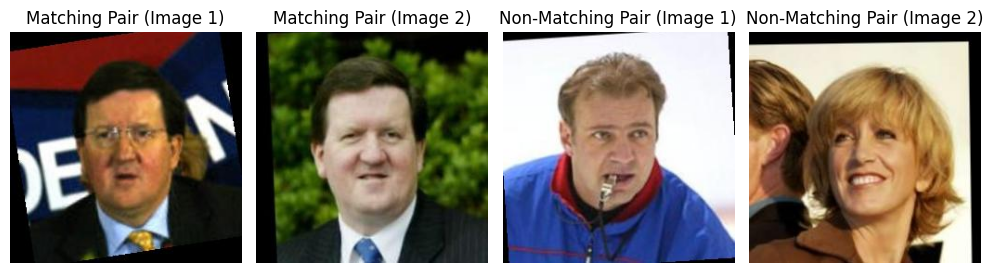

In [ ]:
# Select a random matching pair
matching_indices = [i for i, label in enumerate(all_labels_balanced) if label == 1]
random_matching_index = random.choice(matching_indices)
matching_pair = all_pairs_balanced[random_matching_index]

# Select a random non-matching pair
non_matching_indices = [i for i, label in enumerate(all_labels_balanced) if label == 0]
random_non_matching_index = random.choice(non_matching_indices)
non_matching_pair = all_pairs_balanced[random_non_matching_index]

# Load and display the images
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

img1_matching = Image.open(matching_pair[0])
img2_matching = Image.open(matching_pair[1])
img1_non_matching = Image.open(non_matching_pair[0])
img2_non_matching = Image.open(non_matching_pair[1])

axes[0].imshow(img1_matching)
axes[0].set_title("Matching Pair (Image 1)")
axes[0].axis('off')

axes[1].imshow(img2_matching)
axes[1].set_title("Matching Pair (Image 2)")
axes[1].axis('off')

axes[2].imshow(img1_non_matching)
axes[2].set_title("Non-Matching Pair (Image 1)")
axes[2].axis('off')

axes[3].imshow(img2_non_matching)
axes[3].set_title("Non-Matching Pair (Image 2)")
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Create a dataset Class

In [ ]:
class FacePairsDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

In [ ]:
# Create the dataset instance
full_dataset = FacePairsDataset(all_pairs_balanced, all_labels_balanced, transform=transform)

# Define the split ratio (e.g., 80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 1600
Testing dataset size: 400


In [ ]:
#create a dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Architecture Design

In [ ]:
# Custom Siamese Network
class Custom_Siamese_Networks(nn.Module):
    def __init__(self):
        super(Custom_Siamese_Networks, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=384 * 13 * 13, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=2)
        self.relu = nn.ReLU()

    def forward(self, x1, x2):
        # Forward pass for both input images
        x1 = self.relu(self.conv1(x1))
        x1 = self.pool1(x1)
        x1 = self.relu(self.conv2(x1))
        x1 = self.pool2(x1)
        x1 = self.relu(self.conv3(x1))
        x1 = x1.view(x1.size(0), -1)  # Flatten
        x1 = self.relu(self.fc1(x1))
        x1 = self.relu(self.fc2(x1))
        x1 = self.fc3(x1)

        x2 = self.relu(self.conv1(x2))
        x2 = self.pool1(x2)
        x2 = self.relu(self.conv2(x2))
        x2 = self.pool2(x2)
        x2 = self.relu(self.conv3(x2))
        x2 = x2.view(x2.size(0), -1)  # Flatten
        x2 = self.relu(self.fc1(x2))
        x2 = self.relu(self.fc2(x2))
        x2 = self.fc3(x2)

        return x1, x2


In [ ]:
# Pretrained Siamese Network
class Pretrained_Siamese_Networks(nn.Module):
    def __init__(self, use_pretrained=True):
        super(Pretrained_Siamese_Networks, self).__init__()
        # Load ResNet50 pretrained model
        self.resnet = models.resnet50(pretrained=use_pretrained)
        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=2)
        self.relu = nn.ReLU() # Add ReLU as a layer

        # Modify the fully connected layer if fine-tuning
        self.resnet.fc = nn.Identity()

    def forward(self, x1, x2):
        # Forward pass for both input images
        x1 = self.resnet(x1)
        x2 = self.resnet(x2)

        # Pass through the custom fully connected layers
        x1 = self.fc1(x1)
        #pass to relu
        x1 = self.relu(x1)
        x1 = self.fc2(x1)
        x1 = self.relu(x1)
        x1 = self.fc3(x1)


        x2 = self.fc1(x2)
        x2 = self.relu(x2)
        x2 = self.fc2(x2)
        x2 = self.relu(x2)
        x2 = self.fc3(x2)

        return x1, x2

In [ ]:
# Unified Model Class to switch between Custom and Pretrained
class SiameseFaceID(nn.Module):
    def __init__(self, use_pretrained=True, use_custom_model=False):
        super(SiameseFaceID, self).__init__()

        # Choose which model to use (custom or pretrained)
        if use_custom_model:
            self.model = Custom_Siamese_Networks()
        else:
            self.model = Pretrained_Siamese_Networks(use_pretrained=use_pretrained)

    def forward(self, x1, x2):
        return self.model(x1, x2)

#Loss Function & Hyperparameter Tuning

In [ ]:
def contrastive_loss(output1, output2, label, margin=1.0):
    # Calculate Euclidean distance between the two embeddings
    euclidean_distance = F.pairwise_distance(output1, output2)

    # Contrastive loss
    loss = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                      (1 - label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))

    return loss


# Training the Model

In [ ]:
# Define the training function
def train_model(model, train_dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_labels = []
    total_predictions = []

    for batch_idx, (img1, img2, labels) in enumerate(train_dataloader):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output1, output2 = model(img1, img2)

        # Calculate the loss
        loss = criterion(output1, output2, labels)
        running_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Collect labels and predictions
        total_labels.extend(labels.cpu().numpy())
        euclidean_distance = F.pairwise_distance(output1, output2)
        predictions = (euclidean_distance < 1.0).cpu().numpy()  # Consider margin 1.0 for prediction
        total_predictions.extend(predictions)

    avg_loss = running_loss / len(train_dataloader)
    accuracy = accuracy_score(total_labels, total_predictions)
    precision = precision_score(total_labels, total_predictions)
    recall = recall_score(total_labels, total_predictions)
    f1 = f1_score(total_labels, total_predictions)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")



    return avg_loss, accuracy, precision, recall # Return all metrics

In [ ]:
# Define the evaluation function
def evaluate_model(model, test_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_labels = []
    total_predictions = []

    with torch.no_grad():
        for batch_idx, (img1, img2, labels) in enumerate(test_dataloader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            output1, output2 = model(img1, img2)

            # Calculate the loss
            loss = criterion(output1, output2, labels)
            running_loss += loss.item()

            # Collect labels and predictions
            total_labels.extend(labels.cpu().numpy())
            euclidean_distance = F.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < 1.0).cpu().numpy()
            total_predictions.extend(predictions)

    avg_loss = running_loss / len(test_dataloader)
    accuracy = accuracy_score(total_labels, total_predictions)
    precision = precision_score(total_labels, total_predictions)
    recall = recall_score(total_labels, total_predictions)
    f1 = f1_score(total_labels, total_predictions)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")


    return avg_loss, accuracy, precision, recall # Return all metrics

In [ ]:
# Set the device (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseFaceID(use_pretrained=True, use_custom_model=False).to(device)

# Define the loss function and optimizer
criterion = contrastive_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
# Number of epochs for training
num_epochs = 30

# Variables to store the metrics from the last epoch
last_train_loss = 0.0
last_train_accuracy = 0.0
last_train_precision = 0.0
last_train_recall = 0.0

last_test_loss = 0.0
last_test_accuracy = 0.0
last_test_precision = 0.0
last_test_recall = 0.0

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train the model and get metrics
    train_loss, train_accuracy, train_precision, train_recall = train_model(model, train_dataloader, optimizer, criterion, device)

    # Evaluate the model on validation data and get metrics
    test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_dataloader, criterion, device)

    # Store the metrics from the last epoch
    if epoch == num_epochs - 1:
        last_train_loss = train_loss
        last_train_accuracy = train_accuracy
        last_train_precision = train_precision
        last_train_recall = train_recall

        last_test_loss = test_loss
        last_test_accuracy = test_accuracy
        last_test_precision = test_precision
        last_test_recall = test_recall

# Print overall metrics after training is complete
print("\n--- Overall Metrics (Last Epoch) ---")
print(f"Train Accuracy: {last_train_accuracy:.4f}")
print(f"Train Precision: {last_train_precision:.4f}")
print(f"Train Recall: {last_train_recall:.4f}")

print(f"Test Accuracy: {last_test_accuracy:.4f}")
print(f"Test Precision: {last_test_precision:.4f}")
print(f"Test Recall: {last_test_recall:.4f}")


Epoch 1/30
Training Loss: 0.2323
Accuracy: 0.5719
Validation Loss: 0.1403
Accuracy: 0.6500

Epoch 2/30
Training Loss: 0.1124
Accuracy: 0.7175
Validation Loss: 0.0997
Accuracy: 0.7150

Epoch 3/30
Training Loss: 0.0893
Accuracy: 0.7825
Validation Loss: 0.0771
Accuracy: 0.8025

Epoch 4/30
Training Loss: 0.0763
Accuracy: 0.8013
Validation Loss: 0.0857
Accuracy: 0.8125

Epoch 5/30
Training Loss: 0.0735
Accuracy: 0.8106
Validation Loss: 0.0734
Accuracy: 0.7850

Epoch 6/30
Training Loss: 0.0594
Accuracy: 0.8263
Validation Loss: 0.0762
Accuracy: 0.7900

Epoch 7/30
Training Loss: 0.0529
Accuracy: 0.8506
Validation Loss: 0.0569
Accuracy: 0.8350

Epoch 8/30
Training Loss: 0.0538
Accuracy: 0.8456
Validation Loss: 0.0543
Accuracy: 0.8100

Epoch 9/30
Training Loss: 0.0541
Accuracy: 0.8350
Validation Loss: 0.0753
Accuracy: 0.8800

Epoch 10/30
Training Loss: 0.0487
Accuracy: 0.8662
Validation Loss: 0.0777
Accuracy: 0.8425

Epoch 11/30
Training Loss: 0.0491
Accuracy: 0.8662
Validation Loss: 0.0603
Acc

# Embedding Extraction

In [ ]:
import faiss
import numpy as np
from PIL import Image
import os
import torch
from torchvision import transforms

# Define the function to generate embeddings from the model
def generate_embeddings(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_labels = []
    all_names = []

    with torch.no_grad():
        for batch_idx, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Get embeddings for both images in the pair
            embedding1, embedding2 = model(img1, img2)


            embedding = (embedding1 + embedding2) / 2

            # Use embedding1 for simplicity and consistency with inference
            embedding = embedding1

            # Store the embedding and the label (person's ID)
            all_embeddings.append(embedding.cpu().numpy())  # Convert tensor to numpy array
            all_labels.extend(label.cpu().numpy())


            all_names.extend([f'Person_{label[i]}' for i in range(len(label))])

    # Concatenate the list of embeddings into a single numpy array
    embeddings = np.concatenate(all_embeddings, axis=0)
    return embeddings, all_labels, all_names


# Function to store embeddings in FAISS
def store_embeddings_in_faiss(embeddings, labels, names, index_path='faiss_index.index'):
    # Create a FAISS index (using L2 distance)
    dimension = embeddings.shape[1]  # Number of features in the embedding vector
    faiss_index = faiss.IndexFlatL2(dimension)

    # Add embeddings to the FAISS index
    faiss_index.add(embeddings)

    # Save the index to a file
    faiss.write_index(faiss_index, index_path)

    # Save the labels and names (person's ID or name) for future retrieval
    np.save('labels.npy', np.array(labels))
    np.save('names.npy', np.array(names))

    print(f"Embeddings and FAISS index have been saved to {index_path}")

In [ ]:
#call the generate and store embedding ftn
embeddings, labels, names = generate_embeddings(model, test_dataloader, device)
store_embeddings_in_faiss(embeddings, labels, names)

Embeddings and FAISS index have been saved to faiss_index.index


# Inference Model

In [ ]:
# Preprocess and extract embedding for a single image (single-shot recognition)
def preprocess_and_extract_embedding(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        embedding1, _ = model(image, image)  # Using the same image twice for simplicity

    embedding_np = np.array(embedding1.squeeze().cpu().tolist(), dtype=np.float32)
    return embedding_np

# KNN search using sklearn NearestNeighbors
def knn_search(query_embedding, embeddings, k=1):
    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(embeddings)
    distances, indices = nbrs.kneighbors([query_embedding])
    return indices[0], distances[0] # Return 1D arrays

# KNN search using FAISS
def faiss_knn_search(query_embedding, faiss_index, k=1):
    distances, indices = faiss_index.search(query_embedding.reshape(1, -1), k)
    return indices[0], distances[0] # Return 1D arrays

# Inference: Match a new image to the database using KNN or FAISS

def match_image_to_id(image_path, model, faiss_index, embeddings, labels, names, use_pretrained=True, k=1, use_faiss=True):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    query_embedding = preprocess_and_extract_embedding(model, image_path, device)

    # Perform KNN search using either FAISS or sklearn's NearestNeighbors
    if use_faiss:
        indices, distances = faiss_knn_search(query_embedding, faiss_index, k)
        print(f"Top {k} closest matches using FAISS:")
    else:
        indices, distances = knn_search(query_embedding, embeddings, k)
        print(f"Top {k} closest matches using sklearn KNN:")

    # Ensure we do not access out-of-bounds indices
    k = min(k, len(indices))  # Adjust k to the number of available matches - Corrected line

    for i in range(k):
        idx = indices[i]  # Get the index of the closest match
        print(f"Match {i+1}: ID={labels[idx]}, Name={names[idx]}, Distance={distances[i]}")

    return indices, distances


# Function to load FAISS index
def load_faiss_index(index_path='faiss_index.index'):
    faiss_index = faiss.read_index(index_path)
    labels = np.load('labels.npy')
    names = np.load('names.npy')
    return faiss_index, labels, names

# Function to generate embeddings (just a helper to create the vector database)
def generate_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []
    all_names = []

    with torch.no_grad():
        for batch_idx, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            embedding1, embedding2 = model(img1, img2)
            embedding = embedding1

            all_embeddings.append(embedding.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            all_names.extend([f'Person_{label[i]}' for i in range(len(label))])

    embeddings = np.concatenate(all_embeddings, axis=0)
    return embeddings, all_labels, all_names

# Store embeddings in FAISS (vector database)
def store_embeddings_in_faiss(embeddings, labels, names, index_path='faiss_index.index'):
    dimension = embeddings.shape[1]
    faiss_index = faiss.IndexFlatL2(dimension)
    faiss_index.add(embeddings)
    faiss.write_index(faiss_index, index_path)

    np.save('labels.npy', np.array(labels))
    np.save('names.npy', np.array(names))

    print(f"Embeddings and FAISS index have been saved to {index_path}")

# Example of how to use the inference pipeline
def inference_pipeline(model, image_path, faiss_index, embeddings, labels, names, k=3, use_faiss=True):
    # You can toggle use_faiss to switch between FAISS and sklearn NearestNeighbors
    match_image_to_id(image_path, model, faiss_index, embeddings, labels, names, use_faiss=use_faiss, k=k)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseFaceID(use_pretrained=True, use_custom_model=False).to(device)

# Generate and store embeddings (if needed, call this once to generate the index)
embeddings, labels, names = generate_embeddings(model, train_dataloader, device)
store_embeddings_in_faiss(embeddings, labels, names)

# Load the FAISS index and embeddings
faiss_index, labels, names = load_faiss_index()

# Inference with a new image
image_path = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'
inference_pipeline(model, image_path, faiss_index, None, labels, names, k=3, use_faiss=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Embeddings and FAISS index have been saved to faiss_index.index
Top 3 closest matches using FAISS:
Match 1: ID=0, Name=Person_0, Distance=2.7199625947105233e-06
Match 2: ID=1, Name=Person_1, Distance=3.050648729185923e-06
Match 3: ID=0, Name=Person_0, Distance=5.4787165026937146e-06


In [ ]:
# To use sklearn's KNN instead, just set use_faiss=False
inference_pipeline(model, image_path, faiss_index, embeddings, labels, names, k=3, use_faiss=False)